In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib 
import matplotlib.pyplot as plt
import random
import pprint
from sklearn.metrics.pairwise import euclidean_distances

pp = pprint.PrettyPrinter(indent=0)
%matplotlib inline
sns.set()

samples_to_show = 3
samples_to_generate = 200000
gender_weight = 40

In [2]:
firstnames = [name.strip().capitalize() for name in open('firstnames.txt', 'r').readlines()]
lastnames = [name.strip().capitalize() for name in open('lastnames.txt', 'r').readlines()]

symptoms = [
    'anhedonia',
    'fatigue',
    'appetite_weight',
    'depressed_mood',
    'worthlessness_guilt',
    'suicide',
    ]

treatments = [
    'CBT',
    'SSRI',
    'SNRI',
    'ECT',
    ]

patients = []
id_counter = 0

def generate_patient(with_treatment_outcomes=True):
    global id_counter
    
    d = {
        'patient_id': id_counter,
        'name': '{} {}'.format(random.choice(firstnames), random.choice(lastnames)),
        'age': random.randint(10,110),
        # 0 - Female
        # 1 - Male
        'gender': random.randint(0,1) * gender_weight,
    }

    # 0 - Does not exhibit symptom
    # 100 - Maximum exhibition of symptom
    d.update({symptom: random.randint(0,100) for symptom in symptoms})
    
    if with_treatment_outcomes:
        # None - Treatment has not been tried
        # 0 - Treatment not effective
        # 1 - Treatment mildly effective
        # 2 - Treatment highly effective
        d.update({treatment: random.choice(list(range(3)) + [None]) for treatment in treatments})
    else:
        d.update({treatment: None for treatment in treatments})
        
    id_counter += 1
    
    return d
    
# Generate sample patient data
for patient in range(samples_to_generate):
    d = generate_patient()
    patients += [d]

In [3]:
df = pd.DataFrame(patients)
df = df[['patient_id','name', 'age', 'gender'] + symptoms + treatments]
df.head(samples_to_show)

,patient_id,name,age,gender,anhedonia,fatigue,appetite_weight,depressed_mood,worthlessness_guilt,suicide,CBT,SSRI,SNRI,ECT
0,0,Hadria Monti,108,0,65,56,21,15,54,69,0.0,2.0,0.0,0.0
1,1,Cariotta Marullo,53,0,65,70,100,63,3,91,2.0,0.0,2.0,1.0
2,2,Jacquelynn Wheatley,71,40,35,81,36,25,100,44,2.0,1.0,0.0,2.0


In [30]:
def draw_radar(patient_id, patient2_id=None):
    # Refresh df
    df = pd.DataFrame(patients)
    df = df[['patient_id','name', 'age', 'gender'] + symptoms + treatments]
    
    labels = np.array(symptoms)
    stats = df.loc[patient_id, labels].values

    # Reference - https://www.kaggle.com/typewind/draw-a-radar-chart-with-python-in-a-simple-way
    angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)
    stats = np.concatenate((stats, [stats[0]]))
    angles = np.concatenate((angles, [angles[0]]))

    fig = plt.figure()

    ax = fig.add_subplot(111, polar=True)
    ax.plot(angles, stats, 'o-', linewidth=1)
    ax.fill(angles, stats, alpha=0.25)
    ax.set_thetagrids(angles * 180/np.pi, labels)
    ax.set_title([df.loc[patient_id,"name"]][0])
    ax.set_ylim(0, 100)
    ax.grid(True)
    
    if patient2_id:
        stats2 = df.loc[patient2_id, labels].values
        stats2 = np.concatenate((stats2, [stats2[0]]))
        
        ax.plot(angles, stats2, 'o-', linewidth=1)
        ax.fill(angles, stats2, alpha=0.25, color='green')
        
        p1_gender = 'm' if [df.loc[patient_id,"gender"]][0] > 0 else 'f'
        p2_gender = 'm' if [df.loc[patient2_id,"gender"]][0] > 0 else 'f'
        ax.set_title("{} ({}{}, Blue), {} ({}{}, Green)".format([df.loc[patient_id,"name"]][0], 
                                                                  [df.loc[patient_id,"age"]][0],
                                                                  p1_gender,
                                                                  [df.loc[patient2_id,"name"]][0],
                                                                  [df.loc[patient2_id,"age"]][0],
                                                                  p2_gender,
                                                                  )
                    )

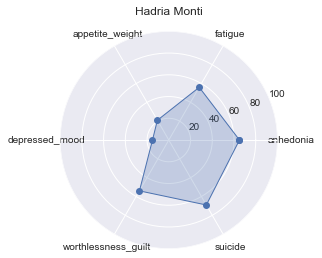

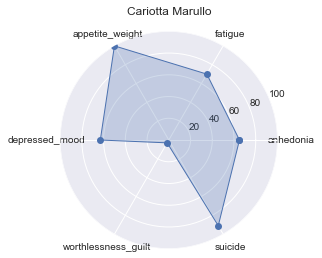

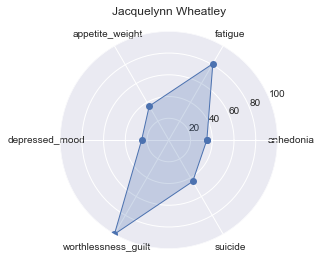

In [20]:
# Uncomment below line to show radar charts
for patient_id in range(samples_to_show): draw_radar(patient_id)

In [6]:
# Create a patient who has not year been treated
untreated_patient = generate_patient(with_treatment_outcomes=False)
patients += [untreated_patient]

In [7]:
patients_data = [[patient[key] for key in symptoms + ['age', 'gender']] for patient in patients]
patients_info = [[patient[key] for key in treatments + ['name', 'patient_id']] for patient in patients]
untreated_patients_data = [[untreated_patient[key] for key in symptoms + ['age', 'gender']]]
untreated_patients_info = [[untreated_patient[key] for key in treatments + ['name', 'patient_id']]]

In [8]:
# Find other patients and their outcomes who have attributes similar to the new patient.
# Output dict format: 
# {attribute1: [similar_patient_value, new_patient_value],
#  attribute2: ...}
def find_similar_cases(similar_cases_to_show, untreated_patients_data, untreated_patients_info):
    untreated_patients_combined = untreated_patients_info[0] + untreated_patients_data[0]
    similarity = euclidean_distances(untreated_patients_data, patients_data).tolist()[0]
    cases = []

    for case in range(samples_to_show):
        most_similar = min(similarity)
        idx = similarity.index(most_similar)
        similarity.remove(most_similar)
        most_similar = patients_info[idx] + patients_data[idx] + [most_similar]
        field_names = treatments + ['name', 'patient_id'] + symptoms + ['age', 'gender']
        case = {field_names[i]: [most_similar[i], untreated_patients_combined[i]] for i in range(len(untreated_patients_combined))}
        # Lower is better
        case['similarity_score'] = round(most_similar[-1], 2)
        cases += [case]
    return cases

similar_cases = find_similar_cases(samples_to_show, untreated_patients_data, untreated_patients_info)
#pp.pprint(similar_cases)

[{'CBT': [None, None],
'ECT': [None, None],
'SNRI': [None, None],
'SSRI': [None, None],
'age': [48, 48],
'anhedonia': [98, 98],
'appetite_weight': [5, 5],
'depressed_mood': [97, 97],
'fatigue': [67, 67],
'gender': [0, 0],
'name': ['Leta Zoldak', 'Leta Zoldak'],
'patient_id': [200000, 200000],
'similarity_score': 0.0,
'suicide': [54, 54],
'worthlessness_guilt': [25, 25]},
{'CBT': [0, None],
'ECT': [None, None],
'SNRI': [None, None],
'SSRI': [2, None],
'age': [48, 48],
'anhedonia': [92, 98],
'appetite_weight': [11, 5],
'depressed_mood': [96, 97],
'fatigue': [74, 67],
'gender': [0, 0],
'name': ['Lyndsie Zacharellis', 'Leta Zoldak'],
'patient_id': [93212, 200000],
'similarity_score': 14.83,
'suicide': [61, 54],
'worthlessness_guilt': [32, 25]},
{'CBT': [0, None],
'ECT': [1, None],
'SNRI': [0, None],
'SSRI': [0, None],
'age': [50, 48],
'anhedonia': [85, 98],
'appetite_weight': [6, 5],
'depressed_mood': [90, 97],
'fatigue': [58, 67],
'gender': [0, 0],
'name': ['Reina Swinburne', 'Leta Zoldak

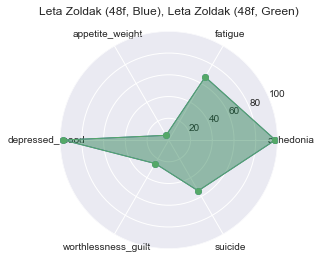

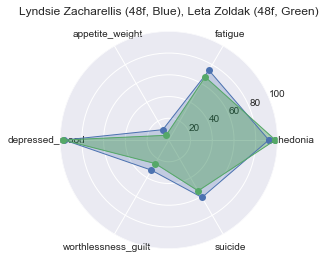

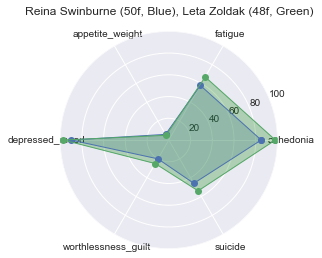

In [31]:
for similar_case in similar_cases:
    case = similar_case['patient_id']
    patient, patient2 = case[0], case[1]
    draw_radar(patient, patient2)

In [10]:
map_treatment_outcomes = {
    None: 'Unknown/Not tried',
    0.0: 'Not effective',
    1.0: 'Somewhat effective',
    2.0: 'Highly effective',
}

closest_match = similar_cases[1]

for treatment in treatments:
    closest_match[treatment] = [map_treatment_outcomes[closest_match[treatment][0]], map_treatment_outcomes[closest_match[treatment][1]]]
 

In [18]:
#pp.pprint(closest_match)
df2 = pd.DataFrame(closest_match)
df2 = df2[['patient_id','name', 'age', 'gender'] + symptoms + treatments]
df2.head()

,patient_id,name,age,gender,anhedonia,fatigue,appetite_weight,depressed_mood,worthlessness_guilt,suicide,CBT,SSRI,SNRI,ECT
0,93212,Lyndsie Zacharellis,48,0,92,74,11,96,32,61,Not effective,Highly effective,Unknown/Not tried,Unknown/Not tried
1,200000,Leta Zoldak,48,0,98,67,5,97,25,54,Unknown/Not tried,Unknown/Not tried,Unknown/Not tried,Unknown/Not tried
